# CS436: Computer Vision Fundamentals - Project Phase / Week2
## 3D Scene Reconstruction and Virtual Tour

#### Name: Syed Muhammad Ashhar Shah
#### Roll Number: 25-03-0009
#### Program: MS-CS

# PHASE 2 (20th November 2025)
---

### Tasks Completed In This Phase

- **Essential Matrix Estimation**

- **Pose Recovery & Disambiguation**

- **Point Cloud Generation**

## Define Imports
- The required libraries for the code are imported here.

In [1]:
import os
import cv2
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Configure Variables
- The variables that are to be used throughout the code are specified here.
    - output_dir = The directory that contains the pre-processed images
    - resized_paths = A list to store the full path of the images
    - images = A list to read each image and store it
    - features = Dictionary that contains SIFT keypoints for each image path
    - descriptors = Dictionary that contains SIFT descriptors for each image path
    - camera_poses = Dictionary that contains the rotation (R) and translation (t) matrices of each camera
    - point_cloud = A global 3D map (initially empty)
    - map_3d_to_keypoint_indices =  A list for each 3D point, track which image keypoints created it

In [2]:
output_dir = r"../Tehzeeb_v2/resized_images"
resized_paths = []
images = []

features = {}           # Stores keypoints (kp) for each image file
descriptors = {}        # Stores descriptors (desc) for each image file
camera_poses = {}       # Stores (R, t) for each image file
point_cloud = np.empty((0, 3), dtype=np.float64) # The 3D map

## Fetch Resized Images

#### Fetch Resized Paths

In [3]:
# fetch the final paths of all the resized images
for f in os.listdir(output_dir):
    ext = os.path.splitext(f)[1]
    if (ext == ".jpg"):
        full_path = os.path.join(output_dir, f)
        resized_paths.append(full_path)
        print(f"Found File: {full_path}")

# sort the paths according to the file names
resized_paths = natsorted(resized_paths)

Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112559.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112547.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112453.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112440.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112528.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112604.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112557.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112507.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112524.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112512.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112601.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112446.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112603.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112518.jpg
Found File: ../Tehzeeb_v2/resized_images/IMG_20251112_112551.jpg
Found File: ../Tehzeeb_v2

#### Open & Store Each Images

In [4]:
# open each image path and store the resultant images in a list
for img_path in resized_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

#### Display The First Two-Images


Displaying first two images...


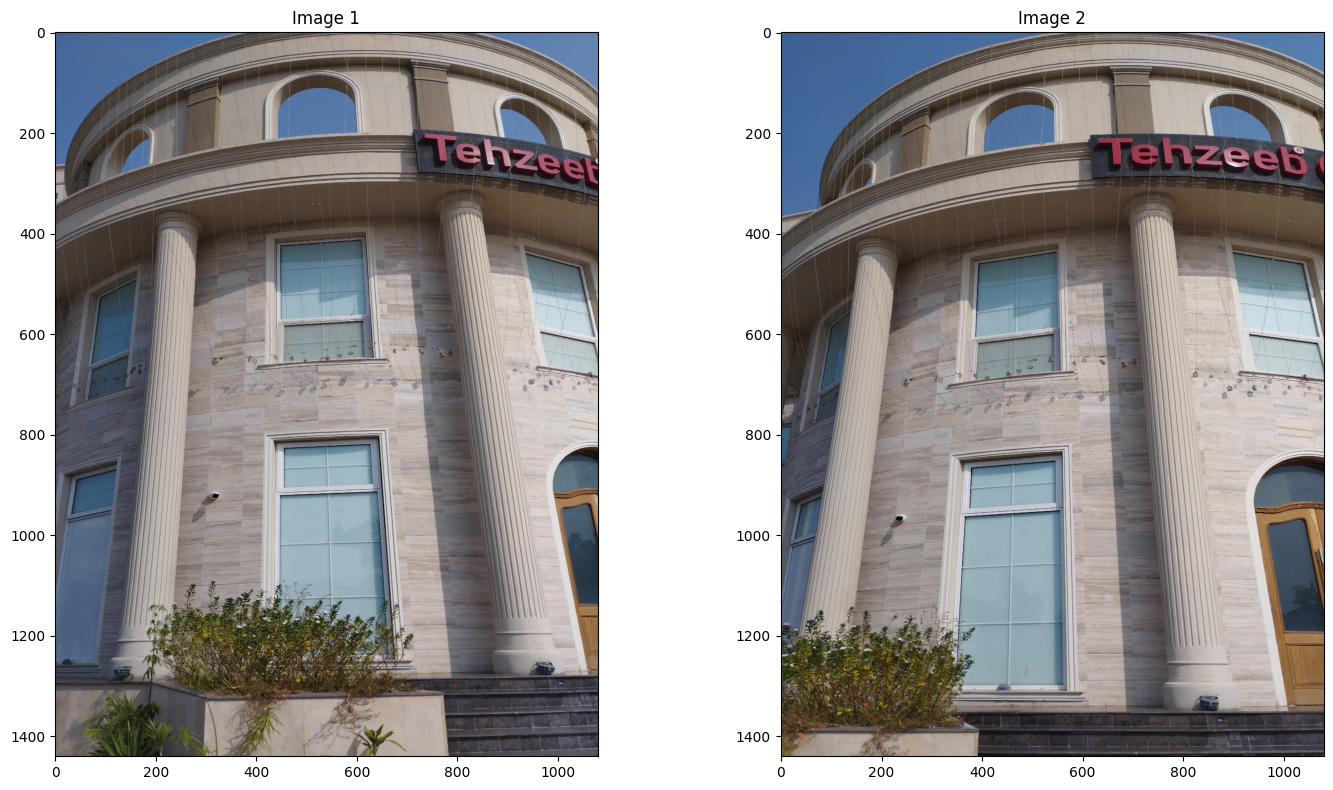

In [5]:
# function to show the images
print(f"\nDisplaying first two images...")

# define grid-like formatting
rows = 1
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

# loop over and display each image
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

## Compute Features & Perform Feature Matching Between Two Consecutive Images
- Compute features between the two images using OpenCV's SIFT feature detector
- Detect matches between two images using OpenCV's FLANN feature matches detector
- Apply lowes ratio test between the two matches to further filter good matches
- Display a subset of the matched images with the match lines in between

#### Function To Compute Features (Keypoints & Descriptors)

In [6]:
def compute_features(image):
    gray_scaled = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray_scaled, None)
    return keypoints, descriptors

#### Function To Compute Matches Between Two Images (Uses Lowes Ratio Test)

In [7]:
def compute_matches(descriptor1, descriptor2, ratio=0.75):
    # matcher configurations
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    # initialize matcher
    flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
    # identify matches
    matches_found = flann_matcher.knnMatch(descriptor1, descriptor2, k=2)
    # apply lowes ratio test using ratio threshold
    final_matches = []
    for m, n in matches_found:
        if m.distance < ratio * n.distance:
            final_matches.append(m)
    return final_matches

Found 512 Matches B/W Image 1 & Image 2


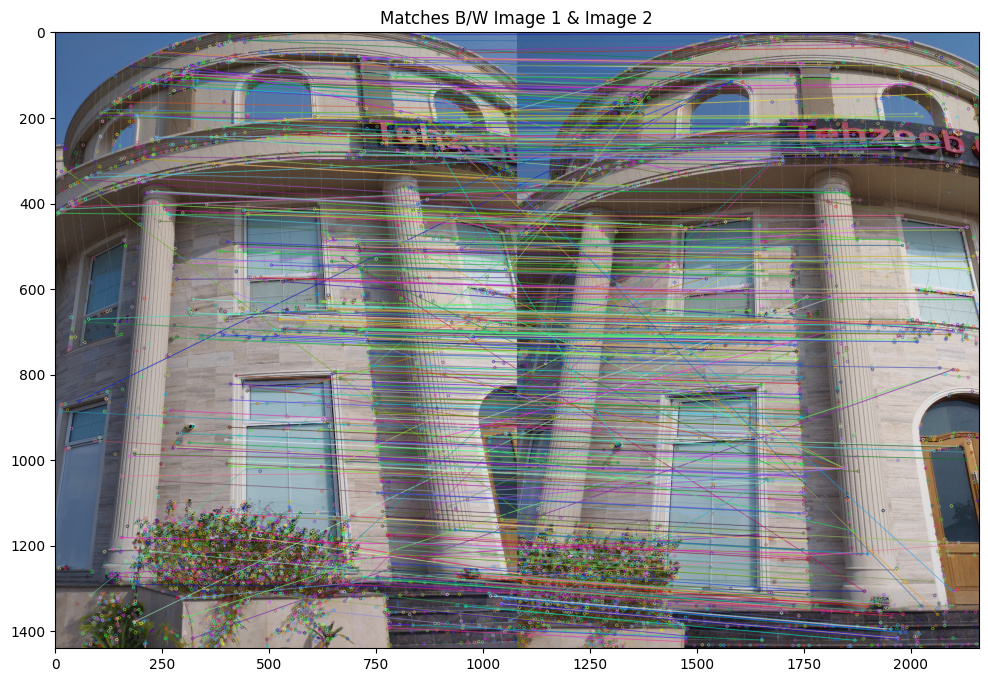

In [8]:
# fetch features for the current image and the next image
kp1, desc1 = compute_features(images[0])
kp2, desc2 = compute_features(images[1])

# find feature matching between the two images
matches = compute_matches(desc1, desc2)
    
print(f"Found {len(matches)} Matches B/W Image 1 & Image 2")
    
# draw the matches and send store the image with matches
matches_visualized = cv2.drawMatches(images[0], kp1, images[1], kp2, matches, None)
    
# display the image
plt.figure(figsize=(20, 8))
plt.imshow(matches_visualized)
plt.title(f"Matches B/W Image 1 & Image 2")
plt.show()
print("\n\n\n")

# Camera Intrinsic & Extrinsic Params

In [9]:
# Fetch The First Image In The Images Array
img_sample = images[0]

print(f"Image Shape: {img_sample.shape}\n")

# Fetch The Image Width & Height
h, w = img_sample.shape[:2]

print(f"Height Of The Image: {h}")
print(f"Width Of The Image: {w}\n")

# Create The Intrinsic Matrix
K = np.array([[w, 0, w/2],
              [0, w, h/2],
              [0, 0, 1]], dtype=np.float64)

print(f"Intrinsic Matrix:\n {K}")

Image Shape: (1440, 1080, 3)

Height Of The Image: 1440
Width Of The Image: 1080

Intrinsic Matrix:
 [[1.08e+03 0.00e+00 5.40e+02]
 [0.00e+00 1.08e+03 7.20e+02]
 [0.00e+00 0.00e+00 1.00e+00]]


# Detect & Store Features (Keypoints & Descriptors)

In [10]:
# Iterate Over The First Two Images
for i, img in enumerate(images[:2]):
    print(f"Detecting Features For: {resized_paths[i]}")
    # For Each Image Compute Its Features
    kp, desc = compute_features(img)
    print(f"Features Detected: {len(kp)}")
    # Store In Dictionary For Later Use
    features[resized_paths[i]] = kp
    descriptors[resized_paths[i]] = desc

Detecting Features For: ../Tehzeeb_v2/resized_images/IMG_20251112_112433.jpg
Features Detected: 4693
Detecting Features For: ../Tehzeeb_v2/resized_images/IMG_20251112_112440.jpg
Features Detected: 4039


In [11]:
print(features.keys())

dict_keys(['../Tehzeeb_v2/resized_images/IMG_20251112_112433.jpg', '../Tehzeeb_v2/resized_images/IMG_20251112_112440.jpg'])


In [12]:
print(descriptors.keys())

dict_keys(['../Tehzeeb_v2/resized_images/IMG_20251112_112433.jpg', '../Tehzeeb_v2/resized_images/IMG_20251112_112440.jpg'])


# Align The Keypoints Between The Two Images

In [13]:
# Fetch The Keys For The First Two Images
img1_file, img2_file = resized_paths[0], resized_paths[1]

In [14]:
# Fetch The Keypoints & Descriptors For The First Two Images
kp1, desc1 = features[img1_file], descriptors[img1_file]
kp2, desc2 = features[img2_file], descriptors[img2_file]

In [15]:
# Compute The Matches Between The Two Images
matches = compute_matches(desc1, desc2)
print(f"Found {len(matches)} robust matches between Image 1 & Image 2")

Found 508 robust matches between Image 1 & Image 2


## Function To Align The Points Using The Fetched Matches

In [16]:
def get_aligned_points(kp1, kp2, matches):
    # Lists To Collect The Indexes Of Matched Keypoints
    img1idx = []
    img2idx = []
    # Iterate Over All The Matches
    for m in matches:
        # For Each Match Fetch & Store The Corresponding Match Points Between The Two Images
        img1idx.append(m.queryIdx)
        img2idx.append(m.trainIdx)
    # Convert To Numpy Arrays
    img1idx = np.array(img1idx)
    img2idx = np.array(img2idx)
    
    # List To Store The Actual x & y Coordinates
    pts1 = []
    pts2 = []
    for i in range(len(img1idx)):
        idx1 = img1idx[i]
        idx2 = img2idx[i]
        # For Each Matched Index, Fetch & Store The Corresponding Points
        pts1.append(kp1[idx1].pt)
        pts2.append(kp2[idx2].pt)
    # COnver To Numpy Arrays
    pts1 = np.array(pts1)
    pts2 = np.array(pts2)
    
    return pts1, pts2, img1idx, img2idx

In [17]:
# Using The Matches & The Overall Key Points Between The Two Images, Filter Those Keypoints That Were Used In The Matches
pts1, pts2, idx1, idx2 = get_aligned_points(kp1, kp2, matches)

# Display For Validation
print(f"Point Matches In Image 1: {pts1.shape}")
print(f"Point Matches In Image 2: {pts2.shape}")
print(f"The Point {pts1[0]} In Image 1 Is The Point {pts2[0]} In Image 2")

Point Matches In Image 1: (508, 2)
Point Matches In Image 2: (508, 2)
The Point [  6.03354311 423.01535034] In Image 1 Is The Point [ 72.89955902 436.01611328] In Image 2


In [18]:
# Convert Each Point Into A List & Store In A List (List Of Lists), Type Used By cv2.findEssentialMat Function
pts1_cv = pts1.astype(np.float64).reshape(-1,1,2)
pts2_cv = pts2.astype(np.float64).reshape(-1,1,2)

# Display For Validation
print(f"Point Matches In Image 1: {pts1_cv.shape}")
print(f"Point Matches In Image 2: {pts2_cv.shape}")
print(f"The Point {pts1_cv[0]} In Image 1 Is The Point {pts2_cv[0]} In Image 2")

Point Matches In Image 1: (508, 1, 2)
Point Matches In Image 2: (508, 1, 2)
The Point [[  6.03354311 423.01535034]] In Image 1 Is The Point [[ 72.89955902 436.01611328]] In Image 2


# Find The Essential Matrix
Use The Cv2 Library: https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga0b166d41926a7793ab1c351dbaa9ffd4

Solve the equation to fetch the essential matrix that contains the Rotation (R) & Translation (t) matrices. The essential matrix related the two 2D points between the images using the formula **P2 x E x P1 = 0**.

Where:
- P1 = normalized coordinates of a point in image 1
- P2 = normalized coordinates of the corresponding point in image 2
- E = Essential Matrix (3×3)

In [19]:
# Fetch The Essential Matrix (E) & The Inliner Coorespondences (mask)
E, mask = cv2.findEssentialMat(pts1_cv, pts2_cv, K, method=cv2.RANSAC, prob=0.99, threshold=2.0)

In [20]:
# Display For Validation
print(f"Essential Matrix:\n {E}")

Essential Matrix:
 [[ 0.0050093  -0.08012738 -0.01342553]
 [ 0.15357629  0.02573889 -0.68965442]
 [-0.02204432  0.70186788  0.01996027]]


# Recover Pose
The Essential Matrix contains the Rotation (R) and the Translation (t) between the two cameras and is related through the equation **E = t x R**. Using this relation, we can fetch the relative camera pose (R, t) between the two views and find out the position of the camera in the next image.

To recover the R & t matrices from the E matrix, we can use the cv2.recoverPose function: https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#gadb7d2dfcc184c1d2f496d8639f4371c0

In [21]:
# Fetch The Rotation & Translation Matrices
_, R, t, mask_pose = cv2.recoverPose(E, pts1_cv, pts2_cv, K, mask=mask)

In [22]:
# Display For Validation
print(f"Rotation Matrix:\n {R}")
print(f"Translation Vector:\n {t}")
print(f"Inliner Points: {len(mask_pose)}")

Rotation Matrix:
 [[ 0.99337802  0.04434402  0.10598926]
 [-0.04742285  0.99851784  0.02670572]
 [-0.10464793 -0.03155519  0.99400859]]
Translation Vector:
 [[-0.99335217]
 [ 0.01603841]
 [-0.11399228]]
Inliner Points: 508


# Filter Points Used To Create The Pose
When we estimate the camera pose using the Essential Matrix, OpenCV returns a mask (mask_pose) indicating which point correspondences are inliers and which are outliers. Only the inliers contribute to a reliable pose, so we must filter out the points that were rejected by the algorithm.

In [23]:
# Flatten the mask_pose into a 1D boolean array
mask_inliers = mask_pose.ravel() == 1
print(f"Sample Mask Inliners (5 Points): {mask_inliers[:5]}")

# Initialize lists to store only the inlier correspondences
pts1_inliers = []
pts2_inliers = []
idx1_inliers = []
idx2_inliers = []

# Iterate over each point in the mask_pose array
for i in range(len(mask_inliers)):
    # Store the indexes & the cooridnates of only the inliner points
    if mask_inliers[i]:
        pts1_inliers.append(pts1[i])
        pts2_inliers.append(pts2[i])
        idx1_inliers.append(idx1[i])
        idx2_inliers.append(idx2[i])
        
# Convert To Numpy Arrays
pts1_inliers = np.array(pts1_inliers)
pts2_inliers = np.array(pts2_inliers)
idx1_inliers = np.array(idx1_inliers)
idx2_inliers = np.array(idx2_inliers)

# Display For Validation
print(f"Sucessful Inliner Points: {len(pts1_inliers)}")

Sample Mask Inliners (5 Points): [False  True False False False]
Sucessful Inliner Points: 339


# Initialize The Camera Poses
Create a dictionary to store the camera poses that we can later use for visualization to display the position of each camera that is used to create the 3D point cloud.

In [24]:
# Create A Dictionary That Stores The Rotation & Translation Matrices For Each Image Path
camera_poses = {img1_file: (np.eye(3), np.zeros((3,1))), img2_file: (R, t)}

# Perform Tirangulation
Take the two corresponding 2D points (pts1, pts2) from two camera views and computing their 3D position in space. Use the cv2.triangulatePoints() function: https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad3fc9a0c82b08df034234979960b778c

In [25]:
def triangulate_points(K, R1, t1, R2, t2, pts1, pts2, min_angle_deg):
    
    # Normalize the Image Points (Convert to Camera Coordinates) = (x, y) = (x, y, 1)
    pts1_h = cv2.convertPointsToHomogeneous(pts1)[:, 0, :]
    pts2_h = cv2.convertPointsToHomogeneous(pts2)[:, 0, :]
    pts1_norm = cv2.convertPointsFromHomogeneous((np.linalg.inv(K) @ pts1_h.T).T)[:, 0, :]
    pts2_norm = cv2.convertPointsFromHomogeneous((np.linalg.inv(K) @ pts2_h.T).T)[:, 0, :]
    
    # Build the Project Matrices for both images P=[R∣t]
    P1 = np.hstack((R1, t1))
    P2 = np.hstack((R2, t2))
    
    # Perform Triangulation & Get A 4xN array of reconstructed points in homogeneous coordinates
    pts4d = cv2.triangulatePoints(P1, P2, pts1_norm.T, pts2_norm.T)
    # Convert the 4xN Homogenous Points to 3xN Non-Homogenous Points
    pts3d = cv2.convertPointsFromHomogeneous(pts4d.T)[:, 0, :]

    # Compute the camera centers where C1 = Camera 1 Centre & C2 = Camera 2 Centre
    C1 = -R1.T @ t1
    C2 = -R2.T @ t2
    
    # Create rays from camera the centers to the triangulated points
    ray1 = pts3d - C1.T
    ray2 = pts3d - C2.T
    
    # Normalize The Ray Vectors
    ray1_norm = ray1 / np.linalg.norm(ray1, axis=1)[:, np.newaxis]
    ray2_norm = ray2 / np.linalg.norm(ray2, axis=1)[:, np.newaxis]

    # Compute the (triangulation) angle between the two rays
    cos_angle = np.sum(ray1_norm * ray2_norm, axis=1)
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle_degrees = np.degrees(np.arccos(cos_angle))

    # Apply The Minimum Angle Threshold
    # If two cameras see the point from almost the same direction, the triangulation is very unstable
    angle_mask = angle_degrees > min_angle_deg
    
    return pts3d, angle_mask

In [26]:
# Fetch The 3D Point Cloud & The Angle Mask
point_cloud_unfiltered, angle_mask = triangulate_points(K, np.eye(3), np.zeros((3,1)), R, t, pts1_inliers, pts2_inliers, min_angle_deg=3.0)

In [27]:
# Apply the Angle Mask To Filter Out Unstable Points
point_cloud = point_cloud_unfiltered[angle_mask]
print(f"Phase 1 complete. Initial 3D map size: {len(point_cloud)}")

Phase 1 complete. Initial 3D map size: 339


# Visualize The 3D & 2D Point Cloud (Static View)

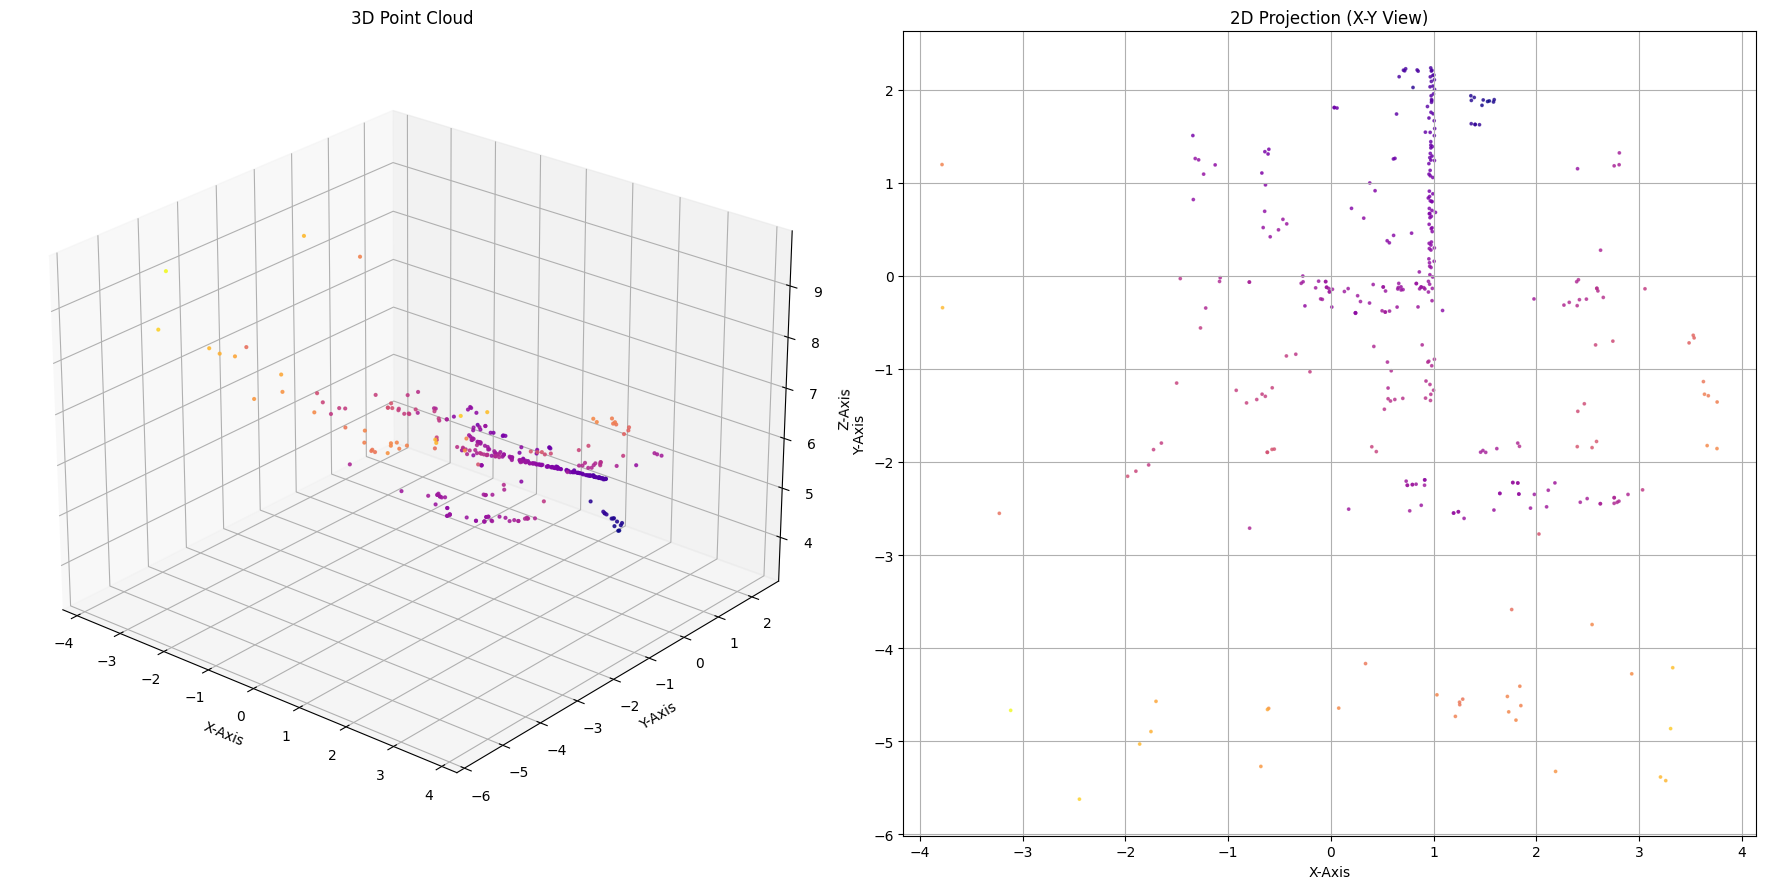

In [28]:
# Extract The XYZ Coordinates From The Point Cloud
X_coords = point_cloud[:, 0]
Y_coords = point_cloud[:, 1]
Z_coords = point_cloud[:, 2]

# Define The Figure Size
fig = plt.figure(figsize=(18, 9))

# Define Parameters For The Scatter Plot
ax_3d = fig.add_subplot(1, 2, 1, projection='3d')
ax_3d.scatter(
    X_coords, Y_coords, Z_coords,
    s=4,
    c=Z_coords,
    cmap='plasma',
    alpha=0.8
)
ax_3d.set_title("3D Point Cloud", fontsize=12)
ax_3d.set_xlabel("X-Axis")
ax_3d.set_ylabel("Y-Axis")
ax_3d.set_zlabel("Z-Axis")
ax_3d.view_init(elev=25, azim=-50)

# Define Paramaters For The 2D Projection
ax_2d = fig.add_subplot(1, 2, 2)
ax_2d.scatter(
    X_coords, Y_coords,
    s=3,
    c=Z_coords,
    cmap='plasma',
    alpha=0.7
)
ax_2d.set_title("2D Projection (X-Y View)", fontsize=12)
ax_2d.set_xlabel("X-Axis")
ax_2d.set_ylabel("Y-Axis")
ax_2d.grid(True)

# Display Both The Plots Side By Side
plt.tight_layout()
plt.show()

# Visualize The 3D & 2D Point Cloud (Dynamic View)
Use the plotty library to create a dynamic scatter plot of the 3D point cloud for better visualization (zoom & rotation options).

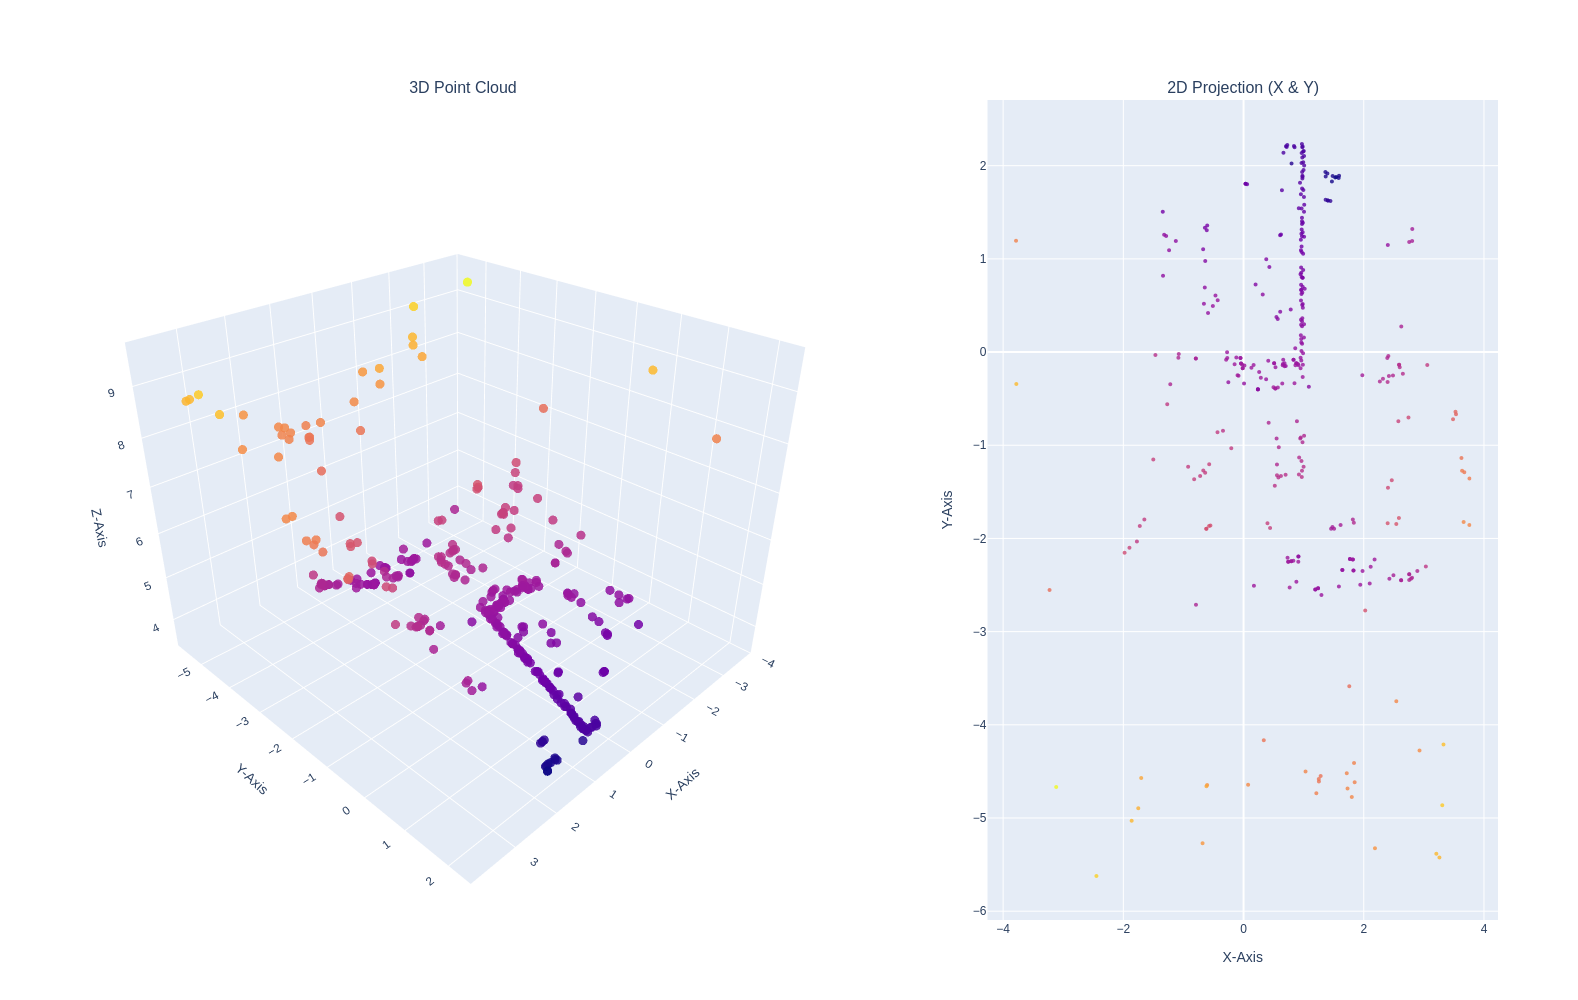

In [29]:
# Extract The XYZ Coordinates From The Point Cloud
X_coords = point_cloud[:, 0]
Y_coords = point_cloud[:, 1]
Z_coords = point_cloud[:, 2]

# Define Subplot Structure 1 Row, 2 Cols
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scene'}, {'type': 'xy'}]],
    column_widths=[0.6, 0.4],
    subplot_titles=("3D Point Cloud", "2D Projection (X & Y)")
)

# Create The 3D Scatter Plot
fig.add_trace(
    go.Scatter3d(
        x=X_coords, y=Y_coords, z=Z_coords,
        mode='markers',
        marker=dict(
            size=3,                     # slightly larger points
            color=Z_coords,             # color based on depth
            colorscale='Plasma',        # updated colormap
            opacity=0.85                # slight transparency
        )
    ),
    row=1, col=1 # Position In Grid
)

# Define Visual Parameters For The 3D View
fig.update_scenes(
    xaxis_title="X-Axis",
    yaxis_title="Y-Axis",
    zaxis_title="Z-Axis",
    aspectmode="data",             # equal aspect ratio
    camera=dict(eye=dict(x=1.5, y=1.5, z=1.2))  # adjusted camera position
)

# Create The 2D Scatter Plot (X & Y Axis)
fig.add_trace(
    go.Scatter(
        x=X_coords, y=Y_coords,
        mode='markers',
        marker=dict(
            size=4,                     # slightly larger points
            color=Z_coords,
            colorscale='Plasma',        # updated colormap
            opacity=0.8
        )
    ),
    row=1, col=2 # Position In Grid
)

# Define Visual Parameters For 2D Plot
fig.update_xaxes(title_text="X-Axis", row=1, col=2)
fig.update_yaxes(title_text="Y-Axis", row=1, col=2)

# Define The Layout
fig.update_layout(
    height=1000,
    width=1600,
    showlegend=False,
)

fig.show()